In [123]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from keras.models import Sequential
from keras.layers import LSTM, Dense

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

LOAD CSV


In [2]:
climate_df = pd.read_csv("./DailyDelhiClimateTrain.csv")

In [3]:
# Set Date as index
climate_df.set_index('date',inplace=True)

In [4]:
climate_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1+ KB


In [6]:
climate_df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [7]:
climate_df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


# Data Cleaning and Visualization

Data Visualization

In this section, I am going to do various visualization techniques to learn more about our dataset.


Text(0.5, 1.0, 'Visualize Date and Meantemp')

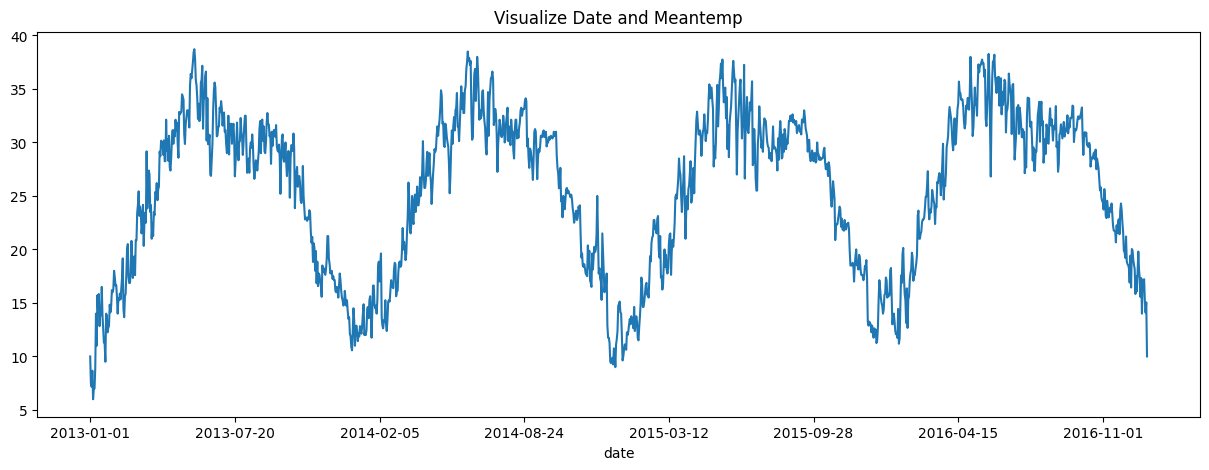

In [11]:
plt.figure(figsize=(15, 5))
climate_df['meantemp'].plot()
plt.title("Visualize Date and Meantemp")

Observation:

From the above plot, we observe that temperature rises exponentially in the first quarter of the year, remains high during the second quarter, seems to be constant during third quarted, and starts to reduce during the last quarter. This is the case in all yearly between 2013 and 2027.


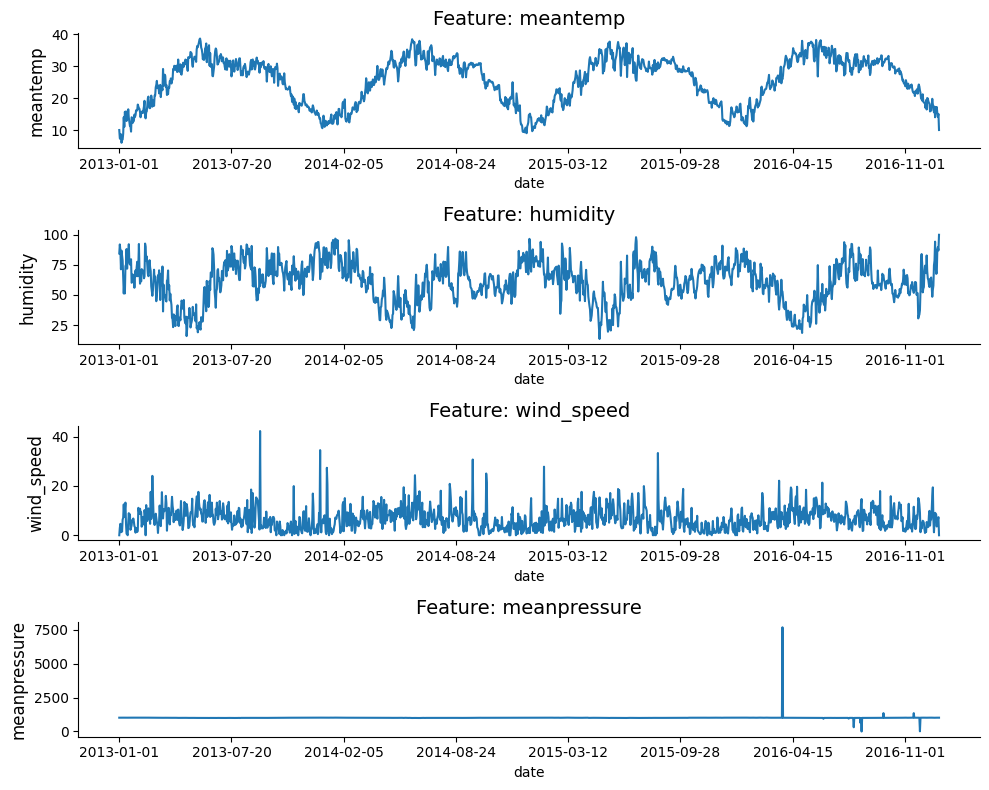

In [14]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
sns.despine()

climate_df['meantemp'].plot(ax=axs[0])
axs[0].set_title(f'Feature: meantemp', fontsize=14)
axs[0].set_ylabel(ylabel='meantemp', fontsize=12)

climate_df['humidity'].plot(ax=axs[1])
axs[1].set_title(f'Feature: humidity', fontsize=14)
axs[1].set_ylabel(ylabel='humidity', fontsize=12)

climate_df['wind_speed'].plot(ax=axs[2])
axs[2].set_title(f'Feature: wind_speed', fontsize=14)
axs[2].set_ylabel(ylabel='wind_speed', fontsize=12)

climate_df['meanpressure'].plot(ax=axs[3])
axs[3].set_title(f'Feature: meanpressure', fontsize=14)
axs[3].set_ylabel(ylabel='meanpressure', fontsize=12)

plt.tight_layout()
plt.show()

Observation:

The tiemseries has constant variation and is stationary. Notably, meanpreassure seems to have some abnormal behaviour between 2016 and 2017. This abnormality is due to the fact there are outliers in our the time series.

## Remove Outliers

In [15]:
def remove_outlier(df, col):
    """
    Parameters
    ==========
    df - Input dataframe
    col - col to remove outliers
    ==========
    Return
    ==========
    Dataframe with column whose outliers have been removed
    """
    values = df[col].values
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    mask = (values > low) & (values < high)
    return df.loc[mask]

In [16]:
climate_df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

<AxesSubplot: xlabel='date'>

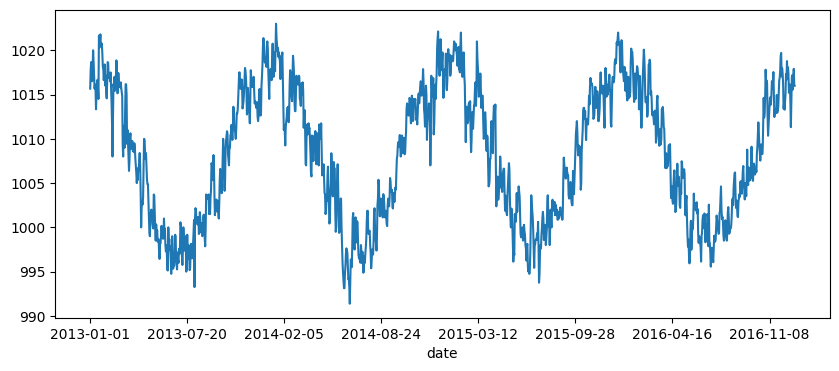

In [17]:
climate_df = remove_outlier(df=climate_df, col='meanpressure')

plt.figure(figsize=(10, 4))
climate_df['meanpressure'].plot(y='meanpressure')

Observation:

The problem seem to have been fixed.

/home/charles/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


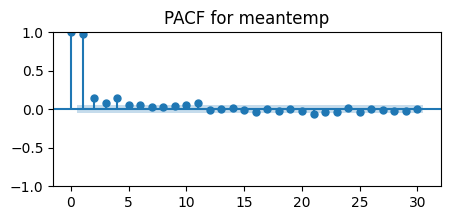

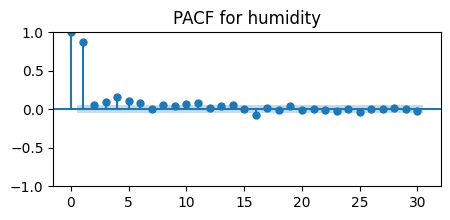

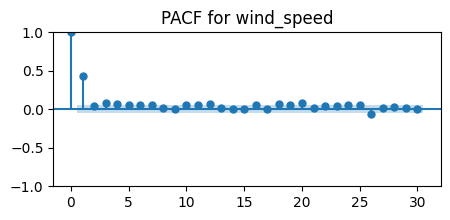

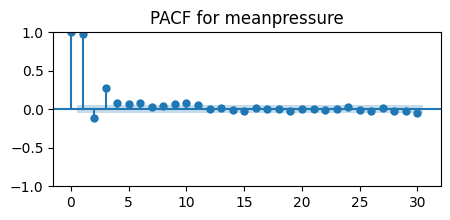

In [18]:
cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
data = climate_df[cols]

# PACF plot for each column
for col in data.columns:
    fig, ax = plt.subplots(figsize=(5, 2))
    sm.graphics.tsa.plot_pacf(data[col], ax=ax, lags=30, title=f'PACF for {col}')
    plt.show()


From PACF of the depentend variables above, we can see that, corrlarion decays to zero and this shows that it is constant and stationery.

# Correlation matrix

<AxesSubplot: >

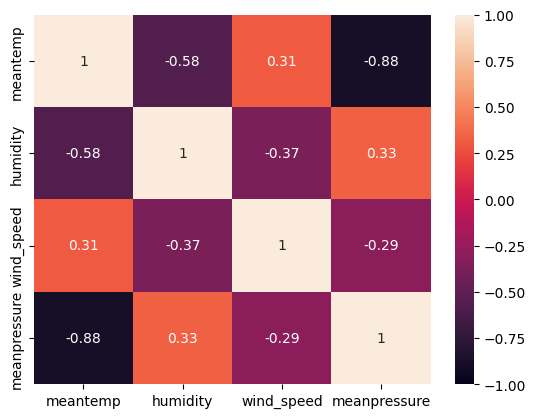

In [19]:
# Heatmap
cliamate_corr = climate_df[cols].corr()
sns.heatmap(cliamate_corr, vmax=1, vmin=-1, annot=True)

In [20]:
print(f"Pearson Correlation Matrix\n{cliamate_corr}")

Pearson Correlation Matrix
              meantemp  humidity  wind_speed  meanpressure
meantemp      1.000000 -0.575328    0.307407     -0.878969
humidity     -0.575328  1.000000   -0.374039      0.332819
wind_speed    0.307407 -0.374039    1.000000     -0.294541
meanpressure -0.878969  0.332819   -0.294541      1.000000


From above heatmap, humidity, meanpressure, and windpeed have high correlation as compared to other features. We can also see that, wind_speed increaseses with decrease in humidity and meanpressure. Let's confirm this by performing decomposition below;

## Seasonal Decomposition

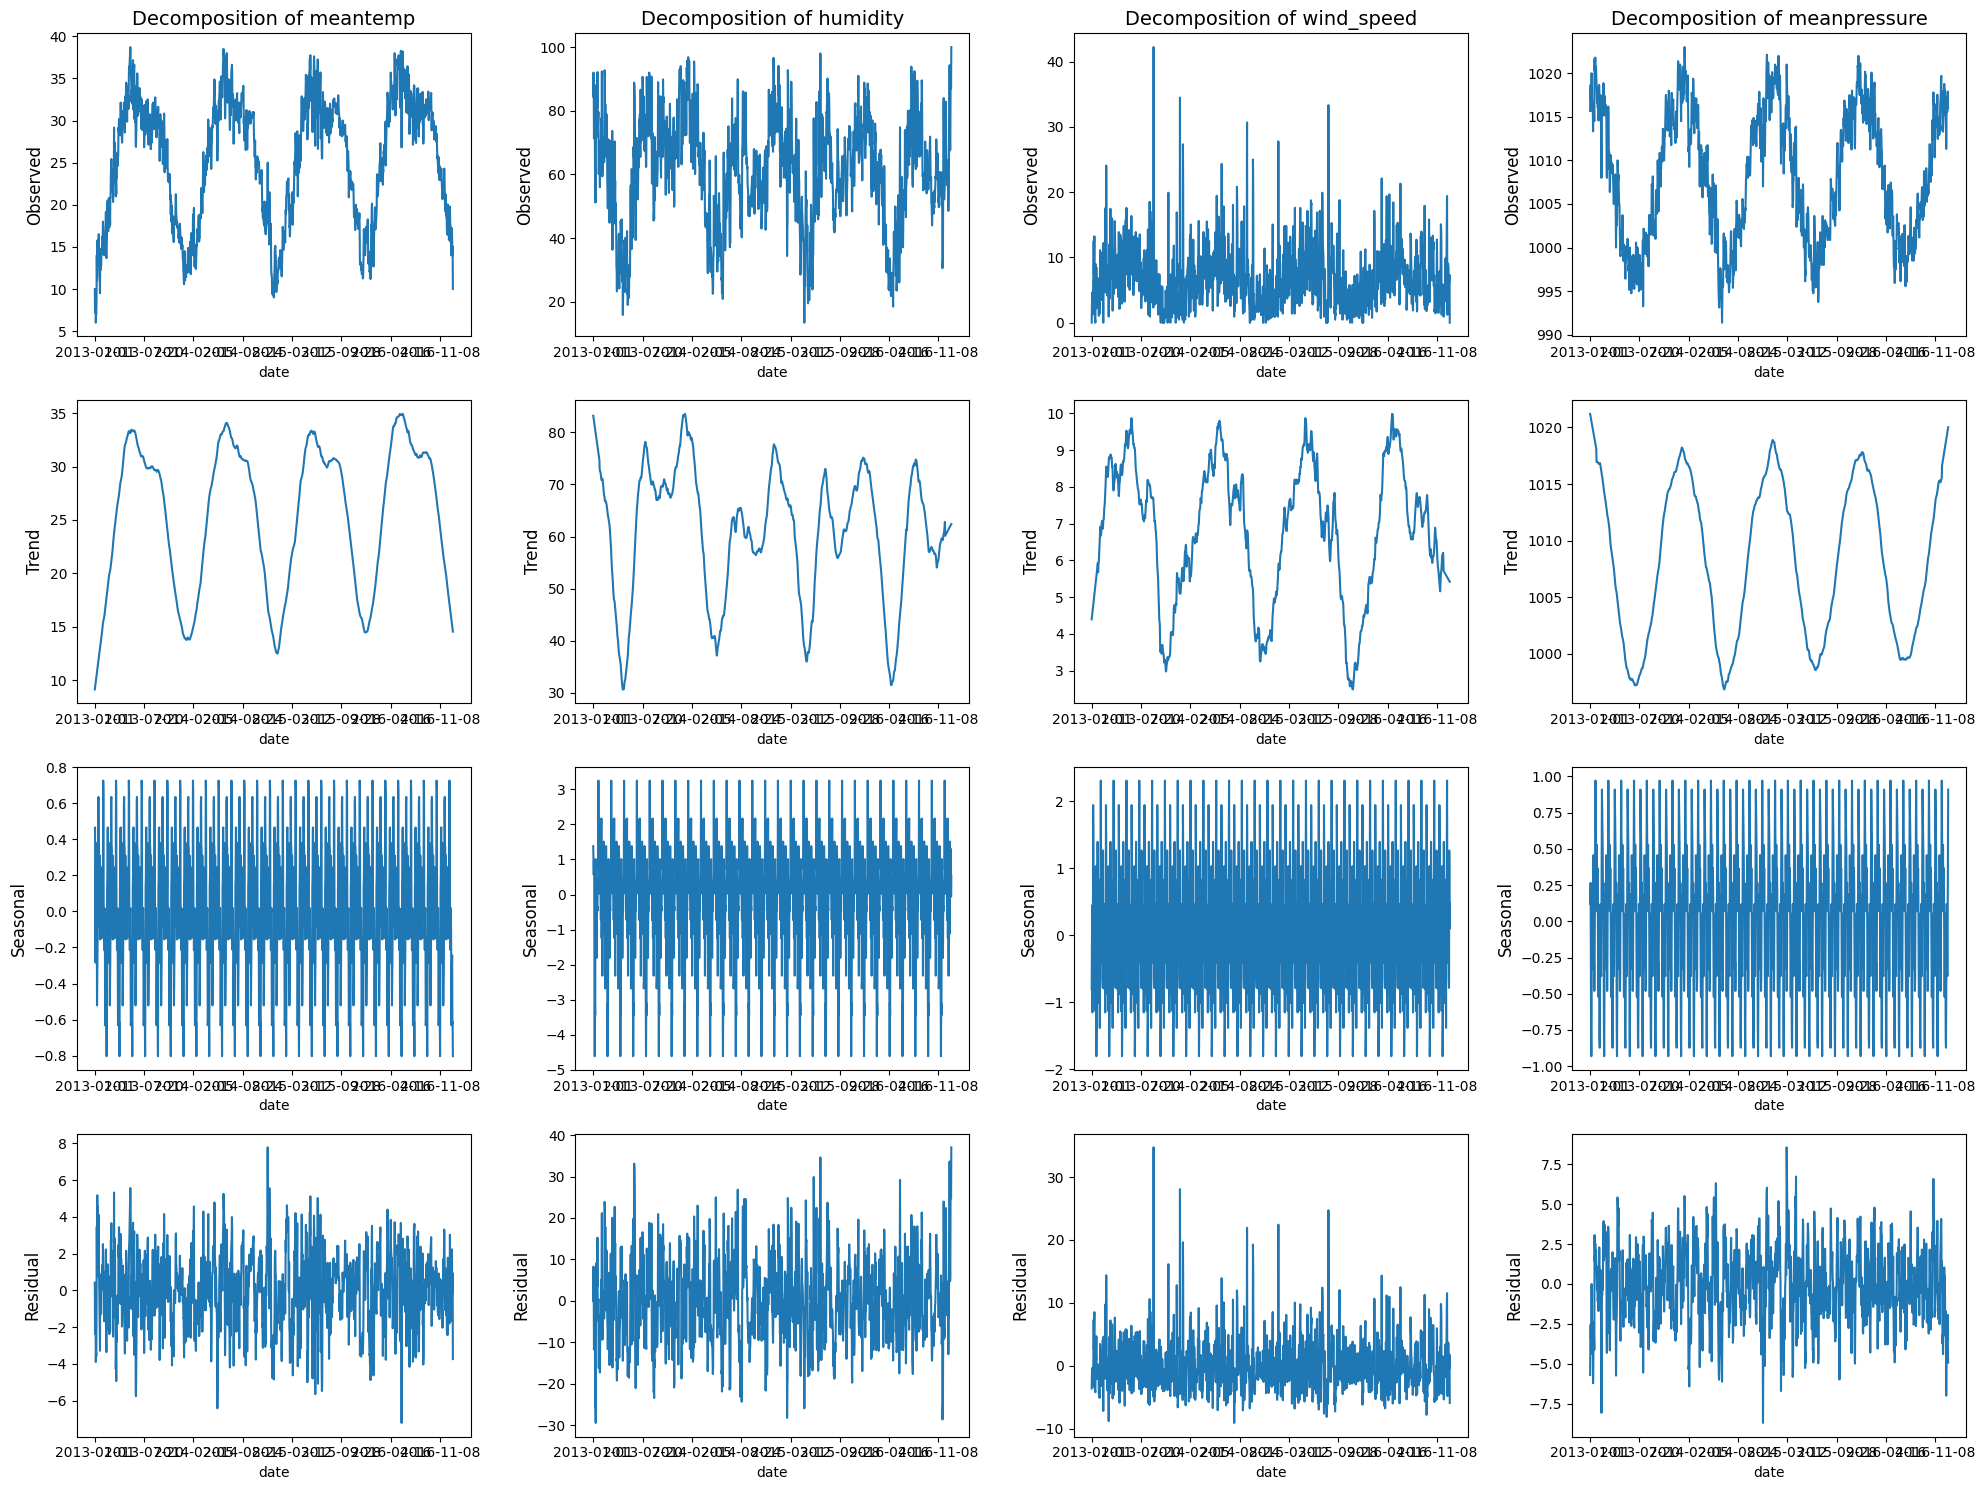

In [21]:
fig, ax =plt.subplots(nrows=4,ncols=4,figsize=(20,15))

for i, col in enumerate(cols):
    
    res = seasonal_decompose(climate_df[col], period=52, model='additive', extrapolate_trend='freq')
    
    ax[0,i].set_title(f'Decomposition of {col}', fontsize=14)
    res.observed.plot(ax=ax[0,i], legend=False)
    ax[0,i].set_ylabel('Observed', fontsize=12)

    res.trend.plot(ax=ax[1,i], legend=False)
    ax[1,i].set_ylabel('Trend', fontsize=12)

    res.seasonal.plot(ax=ax[2,i], legend=False)
    ax[2,i].set_ylabel('Seasonal', fontsize=12)
    
    res.resid.plot(ax=ax[3,i], legend=False)
    ax[3,i].set_ylabel('Residual', fontsize=12)
    
plt.tight_layout()


## Feature Selection Using RANDOM FOREST

In [23]:
# Split the data into features and target variable
X = climate_df.drop(['meantemp'], axis=1)  # Features
y = climate_df['meantemp']                 # Target variable

# Train a random forest regressor model
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X, y)

# Sort feature importances in descending order
importances = sorted(zip(X.columns, rf.feature_importances_), key=lambda x: x[1], reverse=True)

# Print feature importances in ranked order
for feature, importance in importances:
    print(f'{feature}: {importance:.3f}')


meanpressure: 0.861
humidity: 0.106
wind_speed: 0.033


# Data Spliting
training:testing = 80:20

The aim of this project is to predict meantemp in new Delhi.

In [24]:
temp_df = pd.DataFrame(climate_df['meantemp'].copy(), columns=['meantemp'])

In [25]:
temp_df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [30]:
temp_df.value_counts()

meantemp 
31.000000    18
30.000000    15
32.125000    15
30.500000    14
28.500000    14
             ..
23.920000     1
23.833333     1
23.730769     1
23.727273     1
38.714286     1
Length: 611, dtype: int64

In [40]:
train_size = int(len(temp_df) * 0.8)
training = temp_df.iloc[0:train_size]
testing = temp_df.iloc[train_size:len(temp_df)]

1162


In [42]:
training[:5]

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [43]:
testing[:5]

,meantemp
date,
2016-03-08,23.428571
2016-03-09,24.000000
2016-03-10,25.562500
2016-03-11,25.066667
2016-03-12,24.562500


In [49]:
# Prepare Dataset
def climate_dataset(X, y, window):
    XX = []
    YY = []
    for i in range(len(X) - window):
        vals = X.iloc[i: i+window].values
        XX.append(vals)
        YY.append(y.iloc[i+window])
    
    return np.array(XX), np.array(YY)

In [50]:
X = training['meantemp']
y = testing['meantemp']
X_train, y_train = climate_dataset(training, X, 5)
X_test, y_test = climate_dataset(testing, y, 5)

# MODELING
## Baseline Models (average, naive, drift, simple)

In [111]:
# Define the seasonal window length
window_length = 365

# Fit the model to the training set using Exponential Smoothing
model = ExponentialSmoothing(y_train, seasonal_periods=window_length, trend='add', seasonal='add')
fit = model.fit()

# Make predictions on the test set
preds = fit.forecast(len(X_test))

# Compute the MAE of the predictions
mse_exp_smoothing = (abs(y_test - preds)).mean()


/home/charles/.local/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [112]:
# Compute the average value of the training target variable
y_avg = y_train.mean()
preds_avg = [y_avg] * len(y_test)
mse_avg = mean_squared_error(y_test, preds_avg)

In [113]:
# Use the last observed value as a naive baseline
last_observed = y_train[-1]
preds_naive = [last_observed] * len(y_test)
mse_naive = mean_squared_error(y_test, preds_naive)

In [114]:
# Use a linear drift model as a baseline
slope = (y_train[-1] - y_train[0]) / len(y_train)
intercept = y_train[0]
preds_drift = [(slope * i + intercept) for i in range(len(y_test))]
mse_drift = mean_squared_error(y_test, preds_drift)

In [116]:
# Use a simple model that forecasts the next value as the same as the current value
preds_simple = [y_train[-1]] * len(y_test)
mse_simple = mean_squared_error(y_test, preds_simple)

In [117]:
# Print the MAEs for each model
print(f"MAE for Average: {mse_avg:.4f}")
print(f"MAE for Naive: {mse_naive:.4f}")
print(f"MAE for Drift: {mse_drift:.4f}")
print(f"MAE for Simple: {mse_simple:.4f}")
print(f"MAE for ExponentialSmoothing: {mse_exp_smoothing:.4f}")

MAE for Average: 53.3692
MAE for Naive: 62.6141
MAE for Drift: 448.9433
MAE for Simple: 62.6141
MAE for ExponentialSmoothing: 2.6603


# Multi Linear Regression

In [120]:
# Reshape to 2d
X_train_2d = X_train.reshape((X_train.shape[0], X_train.shape[1]))

X_test_2d = X_test.reshape((X_test.shape[0], X_test.shape[1]))

In [121]:
# Fit a multiple linear regression model
model = LinearRegression().fit(X_train_2d, y_train)

# Get the predictions on the test set
y_pred = model.predict(X_test_2d)


In [126]:
accuracy_mtl = r2_score(y_test, y_pred) * 100

In [127]:
print(f"Multilinear Regression: {accuracy_mtl:.2f}  %")

Multilinear Regression: 91.74  %


In [122]:
# Get the last row of X_test_2d
x_pred_2d = X_test_2d[-1, :].reshape(1, -1)

# Predict the target value for the last row
y_pred_one_step = model.predict(x_pred_2d)

# Compare with the corresponding value in y_test
y_true_one_step = y_test[-1]
print(f"True value: {y_true_one_step}, predicted value: {y_pred_one_step}")


True value: 10.0, predicted value: [15.51054496]


## Hypothesis Test

In [75]:
# Perform the F-test on the test set
f_val, p_val = f_regression(X_test_2d, y_test)

# Print the F-test results
print(f"F-value: {f_val}")
print(f"P-value: {p_val}")

F-value: [1071.47695909 1039.21620434 1135.62043608 1589.00237373 2901.53024912]
P-value: [2.18611058e-098 6.70773977e-097 3.06009576e-101 2.40489568e-118
 4.11552784e-151]


In [77]:
# Add a constant term to the X_train matrix
X_train_const = sm.add_constant(X_train_2d)

# Fit a multiple linear regression model using statsmodels
model_sm = sm.OLS(y_train, X_train_const).fit()

# Perform the t-test on the test set
X_test_const = sm.add_constant(X_test_2d)
t_test = model_sm.t_test(X_test_const)

# Print the t-test results
print(t_test.summary())


                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            24.4863      0.070    350.965      0.000      24.349      24.623
c1            24.4182      0.067    364.572      0.000      24.287      24.550
c2            22.9366      0.082    279.395      0.000      22.776      23.098
c3            24.0759      0.085    283.795      0.000      23.909      24.242
c4            24.0835      0.083    289.381      0.000      23.920      24.247
c5            25.6769      0.105    243.732      0.000      25.470      25.884
c6            25.8615      0.100    257.635      0.000      25.665      26.058
c7            26.3110      0.087    303.305      0.000      26.141      26.481
c8            26.8925      0.089    301.384      0.000      26.717      27.068
c9            26.5759      0.055    486.302      0.0

In [81]:
# IC, BIC, RMSE, R-Square, Adjusted R-Squared

# Calculate the mean squared error and R-squared on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1)

# Calculate AIC and BIC
n = X_test.shape[0]
k = X_test.shape[1]
aic = n * np.log(mse) + 2 * k
bic = n * np.log(mse) + k * np.log(n)

# Print the evaluation metrics
print(f"Multi Linear Regression Evaluation\n********************")
print(f"RMSE: {np.sqrt(mse)}")
print(f"R-Square: {r2}")
print(f"Adjusted R-Square: {adj_r2}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

Multi Linear Regression Evaluation
********************
RMSE: 1.637556285574311
R-Square: 0.9173632297180055
Adjusted R-Square: 0.9158875731058271
AIC: 292.1132947812291
BIC: 310.3932538353284


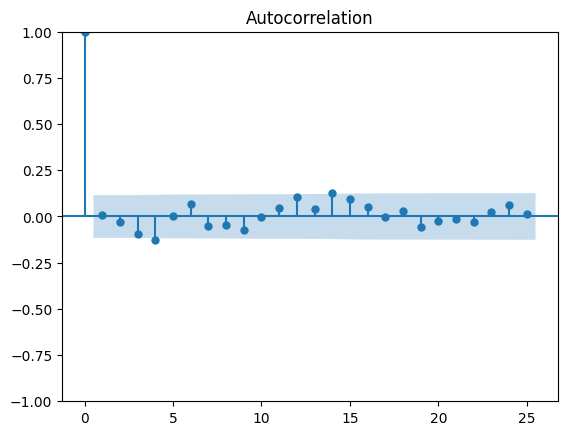

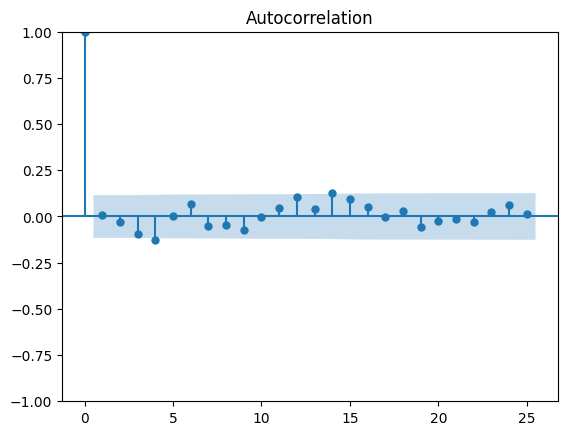

In [82]:
# Calculate the residuals
residuals = y_test - y_pred

# Plot the ACF of the residuals
plot_acf(residuals)

In [84]:
# Q-Variance

# Perform the Breusch-Pagan test on the residuals
bp_test = het_breuschpagan(residuals, X_test_2d)

# Print the Q-variance test results
print(f"Lagrange multiplier statistic: {bp_test[0]}")
print(f"P-value: {bp_test[1]}")
print(f"F-statistic: {bp_test[2]}")
print(f"F p-value: {bp_test[3]}")


Lagrange multiplier statistic: 79.04935789256066
P-value: 2.76929752471959e-16
F-statistic: 21.46682836217308
F p-value: 3.449810172558677e-18


In [85]:
# Variance and mean of the residual
residual_mean = np.mean(residuals)
residual_variance = np.var(residuals)

print(f"Residual mean: {residual_mean}")
print(f"Residual variance: {residual_variance}")

Residual mean: 0.001859406429704669
Residual variance: 2.6815871310316632


# ARMA and SARIMA

ARMA

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

In [86]:
# Fit SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 11))
sarima_results = sarima_model.fit()

# Make predictions using the fitted model
y_pred_sarima = sarima_results.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99844D+00    |proj g|=  1.77017D-01

At iterate    5    f=  1.90566D+00    |proj g|=  4.08821D-02

At iterate   10    f=  1.90001D+00    |proj g|=  2.52809D-03

At iterate   15    f=  1.89989D+00    |proj g|=  2.07651D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   6.413D-06   1.900D+00
  F =   1.8998917229807997     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [90]:
# Fit an ARIMA model to the training data and make predictions on the test set
model = ARIMA(y_train, order=(1, 0, 0))
fit = model.fit()
preds_arima = fit.forecast(len(y_test))

EVALUATE SARIMA AND ARIMA

In [118]:
sarima_mse = mean_squared_error(y_test, y_pred_sarima)
mse_arima = mean_squared_error(y_test, preds_arima)

print("Sarima MAE: ", sarima_mse)
print(f"MAE for ARIMA: {mse_arima:.4f}")

Sarima MAE:  56.13318440408181
MAE for ARIMA: 59.9040


Future predictions

In [108]:
# number of periods to forecast
n_periods = 30

# Make future predictions
y_pred_future = sarima_results.forecast(steps=n_periods)

print(y_pred_future)

[23.65598622 23.69852869 23.76537511 23.65500745 23.90114782 24.1694459
 24.03721306 23.96640614 24.01917101 23.95806399 24.02882253 23.8666022
 23.84941897 23.88193965 23.75184421 23.98664657 24.24842843 24.11245056
 24.0394913  24.09101917 24.02920121 24.09955116 23.937096   23.91977781
 23.95222093 23.82208091 24.05685764 24.31862478 24.18263845 24.10967433]


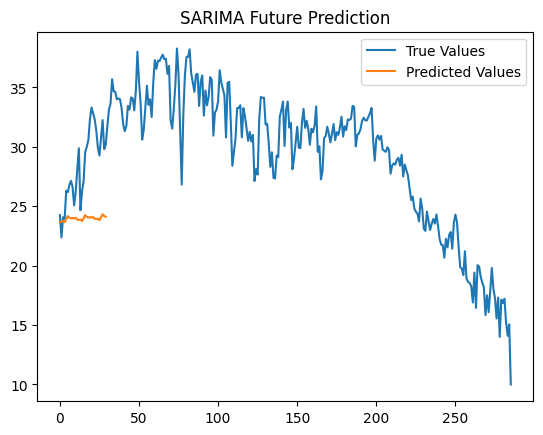

In [109]:
# Plot the predicted future values against true values
plt.plot(y_test, label='True Values')
plt.plot(y_pred_future, label='Predicted Values')
plt.title("SARIMA Future Prediction")
plt.legend()
plt.show()

[23.72173325 23.72900097 23.73609322 23.74301424 23.74976816 23.756359
 23.76279073 23.76906716 23.77519205 23.78116907 23.78700178 23.79269366
 23.79824812 23.80366847 23.80895795 23.81411973 23.81915688 23.82407241
 23.82886926 23.8335503  23.83811831 23.84257604 23.84692614 23.85117121
 23.85531379 23.85935636 23.86330131 23.86715102 23.87090779 23.87457385]


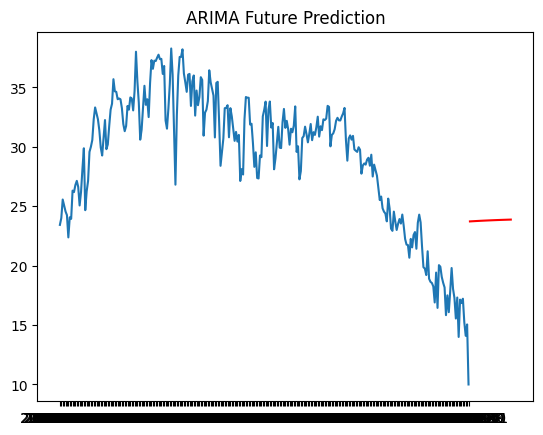

In [110]:
# Forecast the future values
forecast_arima = fit.forecast(n_periods)

# Print the predicted values
print(forecast_arima)

# Plot the predicted values against the original data
plt.plot(y)
plt.plot(np.arange(len(y), len(y)+n_periods), forecast_arima, color='red')
plt.title("ARIMA Future Prediction")
plt.show()

LSTM Model

In [94]:
def LSTMModel(x_train):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
        LSTM(units=50, return_sequences=False),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [96]:
# Instantiate the LSTM model
lstm_model = LSTMModel(X_train)

2023-04-20 13:41:08.913043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-20 13:41:08.913108: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 13:41:08.913151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (charles): /proc/driver/nvidia/version does not exist
2023-04-20 13:41:08.913565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [98]:

# Fit the model to the training data
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
33/33 [==============================] - 9s 74ms/step - loss: 527.9045 - val_loss: 54.9398
Epoch 2/50
33/33 [==============================] - 0s 15ms/step - loss: 117.7202 - val_loss: 87.0179
Epoch 3/50
33/33 [==============================] - 0s 14ms/step - loss: 52.9630 - val_loss: 80.1950
Epoch 4/50
33/33 [==============================] - 0s 15ms/step - loss: 51.3779 - val_loss: 70.6459
Epoch 5/50
33/33 [==============================] - 0s 14ms/step - loss: 46.9937 - val_loss: 57.5821
Epoch 6/50
33/33 [==============================] - 0s 15ms/step - loss: 29.4803 - val_loss: 15.1648
Epoch 7/50
33/33 [==============================] - 1s 18ms/step - loss: 7.1705 - val_loss: 3.3878
Epoch 8/50
33/33 [==============================] - 1s 23ms/step - loss: 4.0254 - val_loss: 2.9309
Epoch 9/50
33/33 [==============================] - 0s 14ms/step - loss: 3.6207 - val_loss: 2.7258
Epoch 10/50
33/33 [==============================] - 0s 15ms/step - loss: 3.4003 - val_loss: 2.

In [99]:
# Predict the values using the LSTM model
y_pred_lstm = lstm_model.predict(X_test)

# Compute the Mean Squared Error (MSE)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM MSE: {mse_lstm}")

9/9 [==============================] - 1s 6ms/step
LSTM MSE: 3.0006816851735714


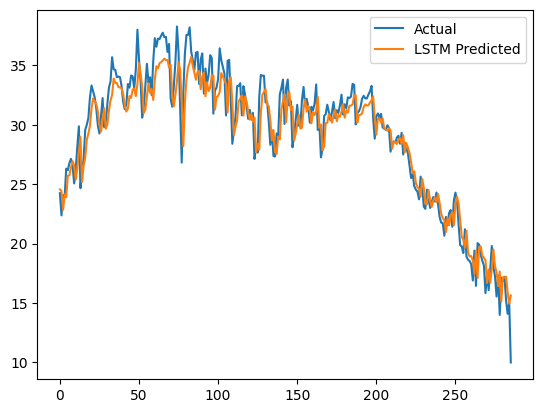

In [101]:
# Visualize the predicted values against the actual values
plt.plot(y_test, label='Actual')
plt.plot(y_pred_lstm, label='LSTM Predicted')
plt.legend()
plt.show()


1/1 [==============================] - 0s 32ms/step


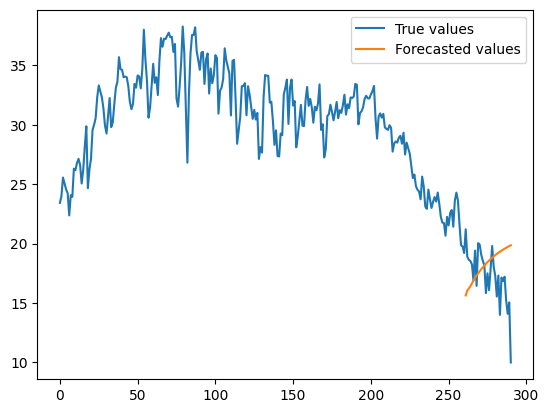

In [104]:
# Prepare the input data for forecasting
n_steps = 5
n_features = 1
last_observation = X_test[-1]
forecast_input = last_observation.reshape((1, n_steps, n_features))

# Forecast the next 30 days of temperatures
n_forecast_days = 30
forecast = []
for i in range(n_forecast_days):
    y_pred = lstm_model.predict(forecast_input)[0]
    forecast.append(y_pred)
    # Update the forecast input with the latest prediction
    forecast_input = np.append(forecast_input[:,1:,:], [[y_pred]], axis=1)

# Plot the forecasted values
plt.plot(range(len(y)), y, label='True values')
plt.plot(range(len(y)-n_forecast_days, len(y)), forecast, label='Forecasted values')
plt.legend()
plt.show()


Forecast Function

In [131]:
def sarima_forecast(model, n_periods):
    """
    Function to make future predictions using a fitted SARIMA model.

    Args:
    model: Fitted SARIMA model.
    n_periods: Number of periods to forecast into the future.

    Returns:
    Array of future predictions.
    """

    # Make future predictions
    y_pred_future = model.forecast(steps=n_periods)

    return y_pred_future


In [133]:
# Apply Sarima Model
# Specify the number of periods to forecast
n_periods = 24

# Use the SARIMA model to forecast future values
forecast = sarima_forecast(model=sarima_results, n_periods=n_periods)

# Print the forecasted values
print(forecast)

[23.65598622 23.69852869 23.76537511 23.65500745 23.90114782 24.1694459
 24.03721306 23.96640614 24.01917101 23.95806399 24.02882253 23.8666022
 23.84941897 23.88193965 23.75184421 23.98664657 24.24842843 24.11245056
 24.0394913  24.09101917 24.02920121 24.09955116 23.937096   23.91977781]
